# Set up

In [0]:
import pandas as pd
import numpy as np
import json
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [0]:
SEED = 42

## Kaggle

In [0]:
!pip install kaggle

!mkdir .kaggle

In [0]:
token = {"username":"adiezp","key":"c016584960f94d57c108a4ed1d22afbc"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [0]:
!kaggle datasets download -d ntnu-testimon/paysim1 -p /content

 91% 166M/182M [00:02<00:00, 76.2MB/s]
100% 182M/182M [00:02<00:00, 87.0MB/s]


In [0]:
!unzip \*.zip

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


## Challenge Data

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Functions

In [0]:
def plot_roc_curve(fpr, tpr, figsize):  
    """Plot ROC curve and random model"""
    plt.figure(figsize=figsize)

    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
    plt.show()
    
def plot_3d_scatter(dfX, dfY, x, y, z, x_name, y_name, z_name, title, targets, colors):
  """Plot 3D scatter"""
  fig = plt.figure(figsize = (15,15))
  ax = fig.add_subplot(111, projection='3d') 

  ax.set_xlabel(x_name, fontsize = 15)
  ax.set_ylabel(y_name, fontsize = 15)
  ax.set_zlabel(z_name, fontsize = 15)

  ax.set_title(title, fontsize = 20)

  for target, color in zip(targets,colors):
      indicesToKeep = dfY == target
      ax.scatter(dfX[x].mask(indicesToKeep)
                 , dfX[y].mask(indicesToKeep)
                 , dfX[z].mask(indicesToKeep)
                 , c = color
                 , s = 50
                 , alpha = .2)

  ax.legend(targets)
  ax.grid()
  
  plt.show()

# Loading the File

## Kaggle

In [0]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Challenge Data

In [5]:
downloaded = drive.CreateFile({'id':'1tjqLNI_Ot18cUGDdDQCVUUi3ElfX6ed1'}) 
downloaded.GetContentFile('test.csv')  
df3 = pd.read_csv('test.csv')

downloaded = drive.CreateFile({'id':'1lLJrGk-cVh2rmrC0vblLBQn_5XCGyPC3'})
downloaded.GetContentFile('train.csv')  
df4 = pd.read_csv('train.csv')

df3['train'] = 0
df4['train'] = 1

df_complete = df3.append(df4, sort=False)
df = df_complete.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'action':'type'})

df = df.set_index('Id')
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,train,isFraud
Id,,,,,,,,,,,,
10,1,CASH_IN,30351.46,C2034314619,20471.89,50823.35,C7981985719,0.0,0.0,0,0,NaN
11,1,CASH_IN,154608.19,C1674092813,15942.39,170550.58,C2328592835,0.0,0.0,0,0,NaN
12,1,CASH_IN,65001.79,C1674092813,170550.58,235552.37,C8900687788,0.0,0.0,0,0,NaN
15,1,CASH_IN,74554.57,C4690721973,12028.36,86582.93,C1064763853,0.0,0.0,0,0,NaN
16,1,CASH_IN,237586.90,C4690721973,86582.93,324169.83,C9879333923,0.0,0.0,0,0,NaN


In [6]:
df.shape

(3352887, 12)

# Exploratory DA

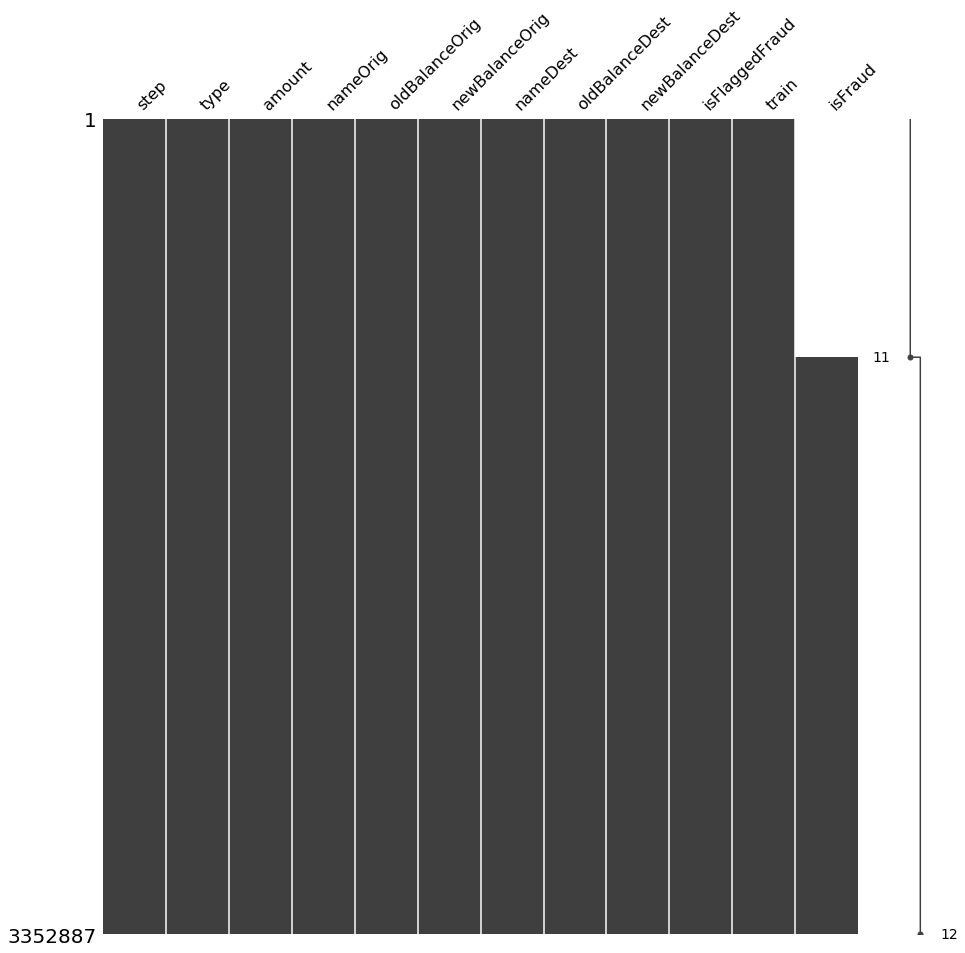

In [7]:
msno.matrix(df, figsize=(15,15))
plt.show()

## Data Challenge

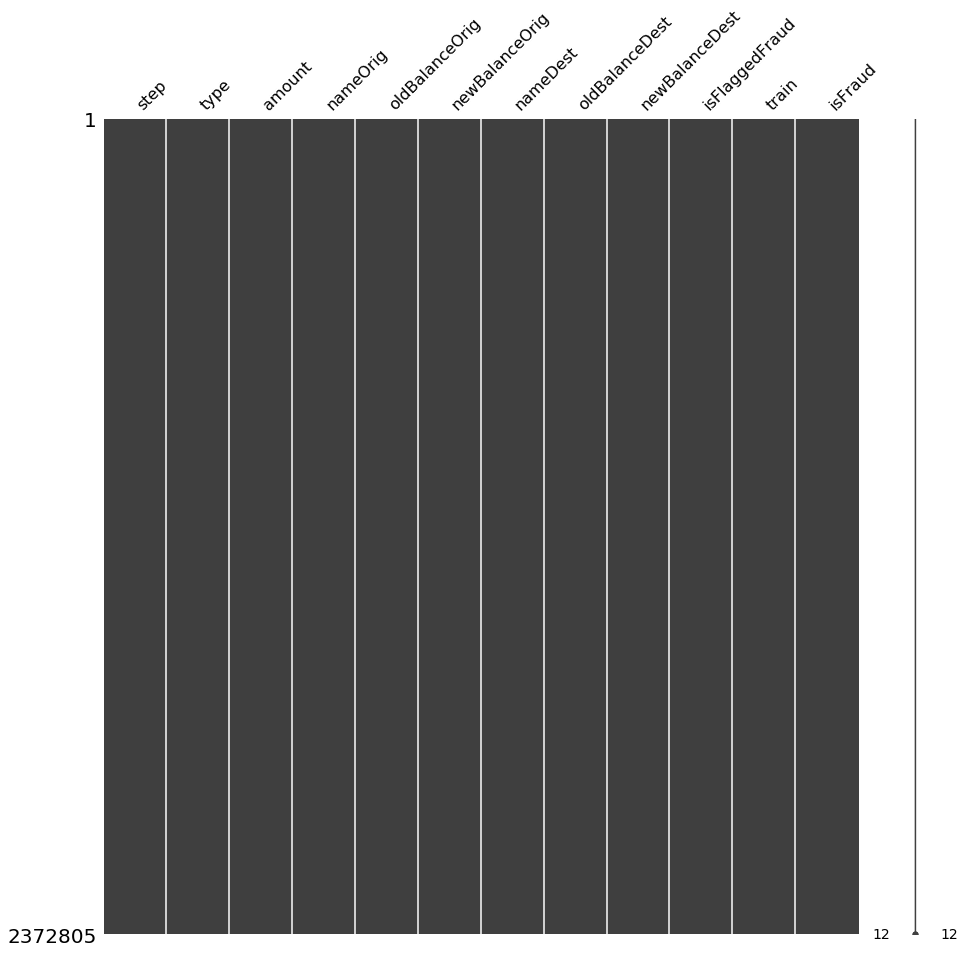

In [8]:
msno.matrix(df[df.train == 1], figsize=(15,15))
plt.show()

## General

In [0]:
df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


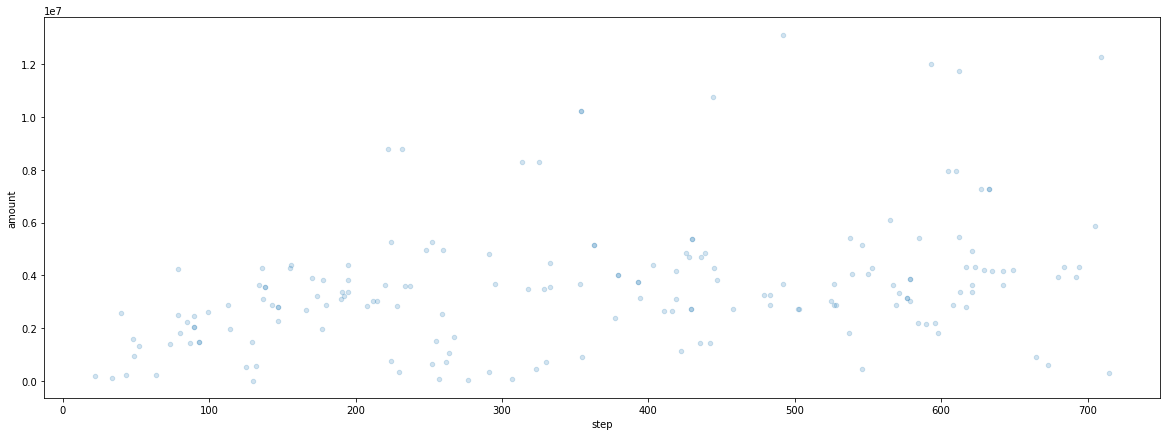

In [9]:
df[df.isFraud == 1][['step','amount']].plot.scatter(x='step',y='amount', alpha=.2, figsize=(20,7))
plt.show()


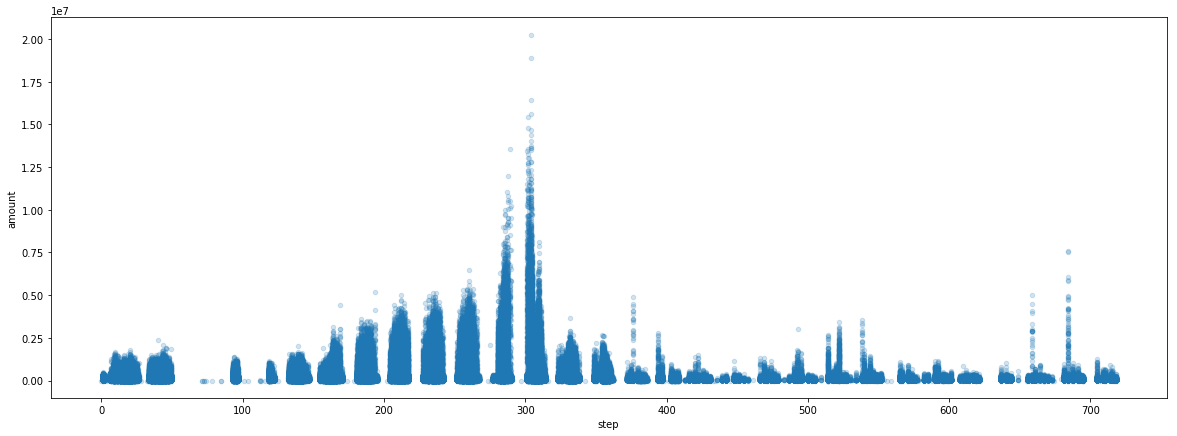

In [10]:
"""We can see a pattern between those two plots. Any big transactions that are less that 250 steps or bigger than 350 are more than likely fraud"""
df[df.isFraud == 0][['step','amount']].plot.scatter(x='step',y='amount', alpha=.2, figsize=(20,7))
plt.show()

In [11]:
"""We see that the only two transaction types that worry us are CASH_OUT and TRANSFER"""
set(df[df.isFraud == 1].type) 

{'CASH_OUT', 'TRANSFER'}

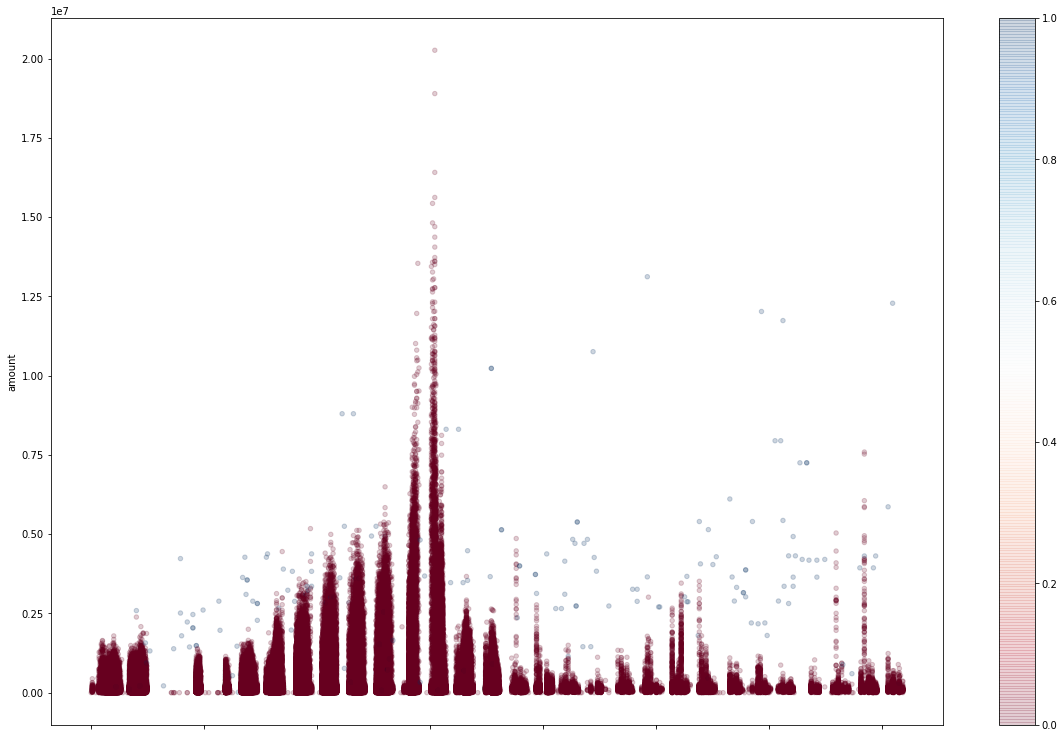

In [12]:
df[df.type.isin(('CASH_OUT', 'TRANSFER'))][['step','amount']].plot.scatter(x='step',y='amount', c=df.isFraud[df.type.isin(('CASH_OUT', 'TRANSFER'))], alpha=.2, figsize=(20,13), colormap='RdBu')
plt.show()

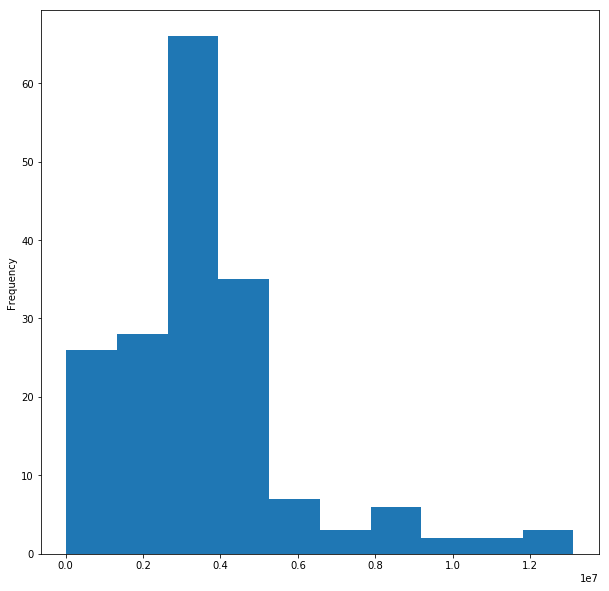

In [13]:
plt.figure(figsize=(10,10))
df[(df.isFraud == 1)].amount.plot.hist(bins=10)
plt.show()

# Feature Engineering

In [6]:
%%time
"""New features that seem relevant"""
df['fullWithdraw'] = df.apply(lambda row : 1 if (row.amount - row.oldBalanceOrig) == 0 else 0, axis=1)
df['bothZero'] = df.apply(lambda row : 1 if (row.newBalanceOrig == 0) & (row.oldBalanceDest == 0) else 0, axis=1)

CPU times: user 3min 31s, sys: 1.2 s, total: 3min 33s
Wall time: 3min 33s


In [7]:
%%time
df['errorOrig'] = df.oldBalanceOrig - df.amount - df.newBalanceOrig
df['errorDest'] = df.oldBalanceDest + df.amount - df.newBalanceDest

CPU times: user 104 ms, sys: 6.94 ms, total: 111 ms
Wall time: 98.5 ms


In [0]:
values = df.type.value_counts() / df.type.value_counts().sum()
df = df.join(values, on='type', rsuffix='_dummy')

In [9]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,train,isFraud,fullWithdraw,bothZero,errorOrig,errorDest,type_dummy
Id,,,,,,,,,,,,,,,,,
10,1,CASH_IN,30351.46,C2034314619,20471.89,50823.35,C7981985719,0.0,0.0,0,0,NaN,0,0,-60702.92,30351.46,0.439883
11,1,CASH_IN,154608.19,C1674092813,15942.39,170550.58,C2328592835,0.0,0.0,0,0,NaN,0,0,-309216.38,154608.19,0.439883
12,1,CASH_IN,65001.79,C1674092813,170550.58,235552.37,C8900687788,0.0,0.0,0,0,NaN,0,0,-130003.58,65001.79,0.439883
15,1,CASH_IN,74554.57,C4690721973,12028.36,86582.93,C1064763853,0.0,0.0,0,0,NaN,0,0,-149109.14,74554.57,0.439883
16,1,CASH_IN,237586.90,C4690721973,86582.93,324169.83,C9879333923,0.0,0.0,0,0,NaN,0,0,-475173.80,237586.90,0.439883


## Data Challenge

In [0]:
num_cols = df.select_dtypes(np.number).columns
cat_cols = df.select_dtypes(np.object).columns
target = 'isFraud'

In [0]:
trainX = df[df.train == 1]
testX = df[df.train == 0]

trainY = df[df.index.isin(trainX.index.to_list())][target]
testY = df[df.index.isin(testX.index.to_list())][target]

In [0]:
X_cols = [c for c in df[num_cols].columns if c not in [target, 'Id', 'train']]

In [0]:
trainX = trainX[X_cols]
testX = testX[X_cols]

# Feature selection

In [0]:
"""We standarize the num cols"""
scaler = MinMaxScaler()
scaler.fit(trainX)
X = scaler.transform(trainX)

"""Select the K Best"""
selectKBest = SelectKBest(chi2, k=10).fit(X, trainY)
mask = selectKBest.get_support()

"""My new dataframe"""
trainX_kbest = trainX[[*[c for c, b in zip(X_cols, mask) if b]]]
testX_kbest = testX[[*[c for c, b in zip(X_cols, mask) if b]]]

ml_df = pd.concat([trainY, trainX_kbest], axis =1)

## Data Challenge

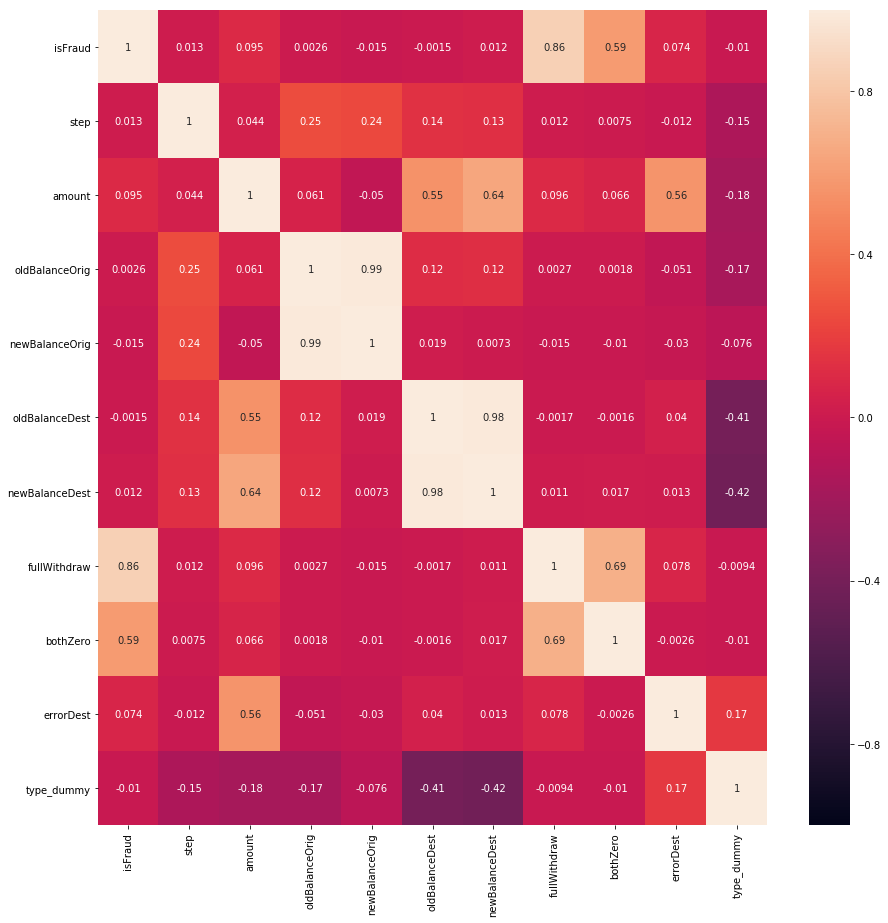

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(pd.concat([trainY, trainX_kbest], axis=1).corr(), vmin=-1, vmax=1, annot=True)
plt.show()

# Modeling

## XGBClassifier

In [15]:
%%time
weights = (ml_df[target] == 0).sum() / (1.0 * (ml_df[target] == 1).sum())
clf = XGBClassifier(max_depth = 5, scale_pos_weight = weights, n_jobs = 4)
clf = clf.fit(trainX_kbest, trainY)

## Just adding here fullWithdraw will increase the performance to "unbeliebable" levels

CPU times: user 11min 52s, sys: 1.01 s, total: 11min 53s
Wall time: 6min 9s


In [17]:
probabilities = clf.predict_proba(trainX_kbest)

print('AUPRC: {}'.format(average_precision_score(trainY, probabilities[:, 1])))
print('AUC: {}'.format(roc_auc_score(trainY,probabilities[:, 1])))

AUPRC: 0.9954273901310594
AUC: 0.999999668503792


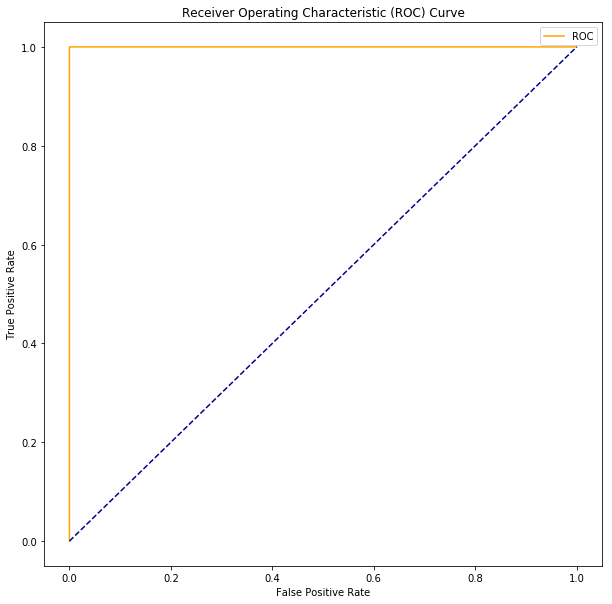

In [19]:
fpr, tpr, thresholds = roc_curve(trainY, probabilities[:, 1])
plot_roc_curve(fpr, tpr, figsize=(10,10))

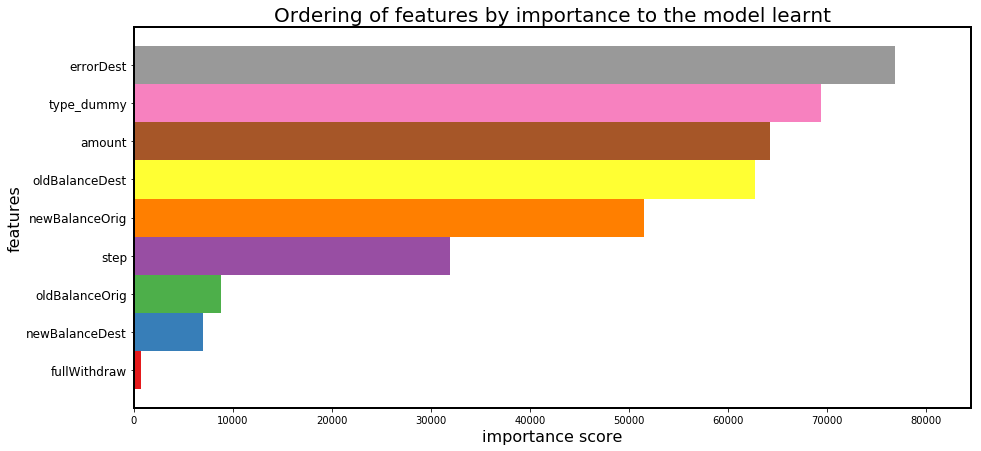

In [20]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);


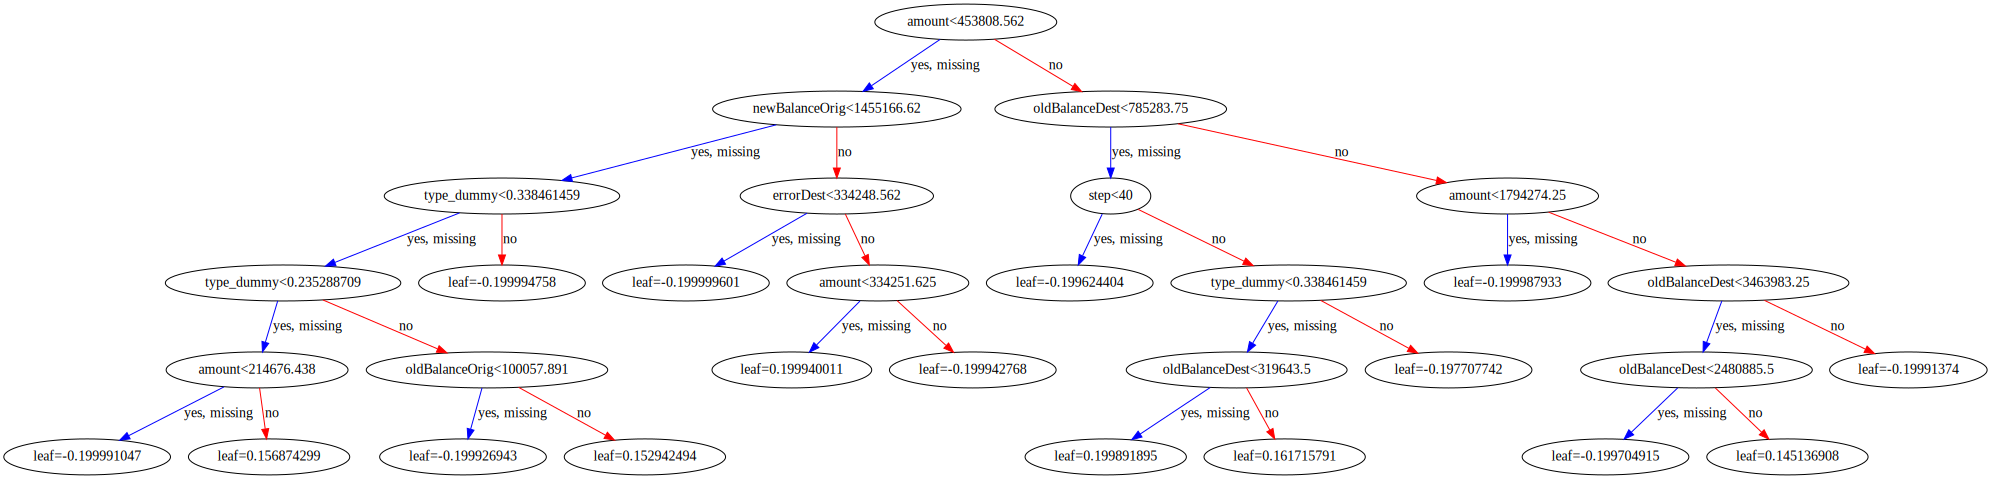

In [23]:
to_graphviz(clf)

## SVM & PCA

In [0]:
pca = PCA(n_components=3)
pc = pca.fit_transform(trainX)
trainX_pca = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3'])
pc = pca.transform(testX)
testX_pca = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3'])

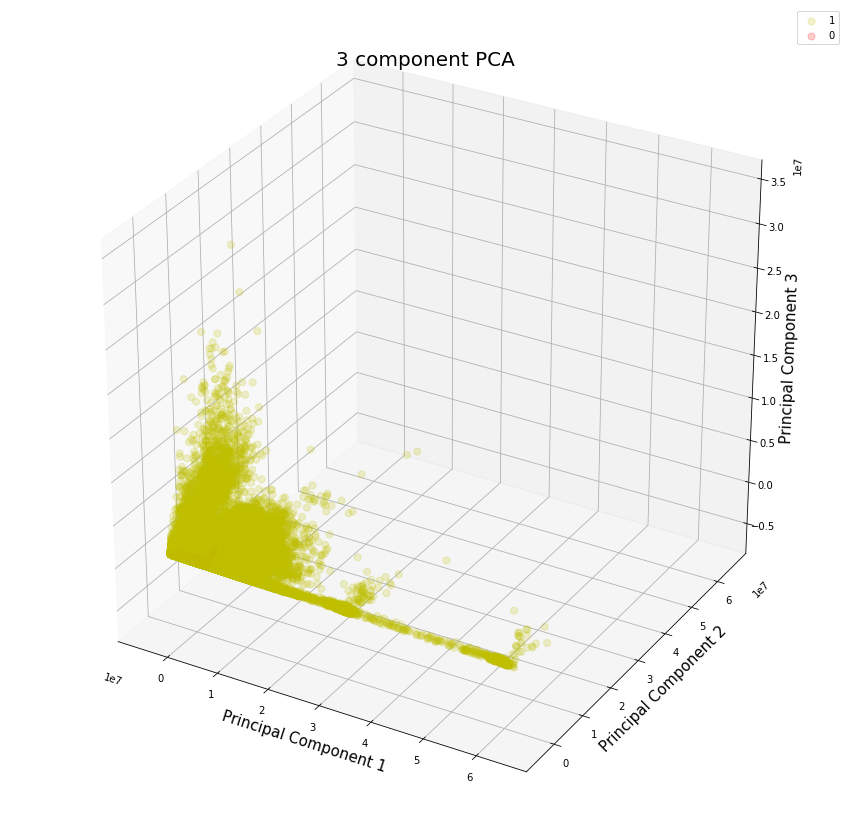

In [25]:
plot_3d_scatter(trainX_pca, trainY, 'PC1','PC2','PC3','Principal Component 1','Principal Component 2','Principal Component 3','3 component PCA', [1,0], ['y', 'r'])

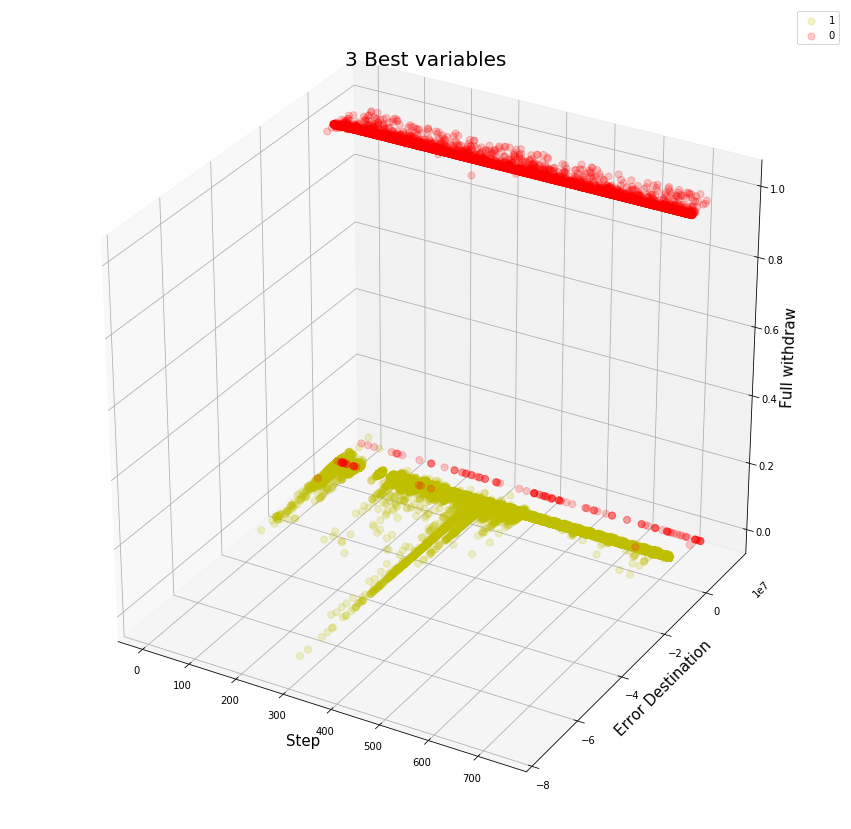

In [0]:
plot_3d_scatter(trainX, trainY, 'step','errorDest','fullWithdraw','Step','Error Destination','Full withdraw','3 Best variables', [1,0], ['y', 'r'])

In [22]:
## After looking at those two plots, I've decided that SVM is not going to be a good model to apply in this data.

%%time
svm_model = svm.SVC(gamma='scale', verbose=5, probability=True)
svm_model.fit(trainX_pca, trainY)

[LibSVM]AUPRC = 0.6477686733984432
CPU times: user 28min 23s, sys: 915 ms, total: 28min 24s
Wall time: 28min 24s


In [23]:
probabilities = svm_model.predict_proba(trainX_pca)
print('AUPRC = {}'.format(average_precision_score(trainY, probabilities[:, 1])))
print('AUC: {}'.format(roc_auc_score(trainY,probabilities[:, 1])))

AUPRC = 0.6477686733984432
AUC: 0.9144599583670123


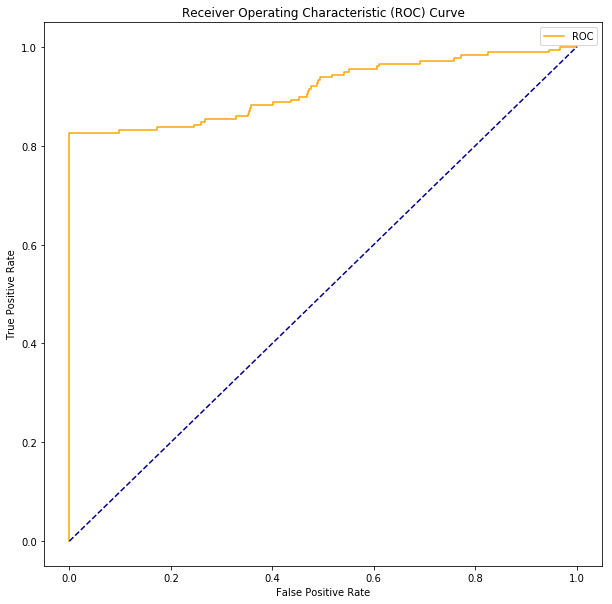

In [24]:
fpr, tpr, thresholds = roc_curve(trainY, probabilities[:, 1])
plot_roc_curve(fpr, tpr, figsize=(10,10))

## Voting Classifier (In progress)

In [0]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = SEED)
clf2 = RandomForestClassifier(random_state = SEED)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(trainX, trainY)

# File creation

In [0]:
predictions_xbost = clf.predict(testX_kbest)
xbost_csv = pd.DataFrame(zip(testX.index, predictions_xbost), columns=['id', 'value'])

predictions_svm = svm_model.predict(testX_pca)
svm_csv = pd.DataFrame(zip(testX.index, predictions_svm), columns=['id', 'value'])

In [53]:
xbost_csv.equals(svm_csv)

False

In [96]:
ne = (xbost_csv != svm_csv)
print('There are {} different predictions between xbost and svm'.format(sum(ne.value)))
print('_'*100)

differences = np.where(xbost_csv != svm_csv)

xbost = xbost_csv.values[differences]
svm = svm_csv.values[differences]

comparison = pd.DataFrame({'xbost_value': xbost, 'svm_value': svm}, index=differences[0])

print('See below values in xbost:')
print(str(comparison.xbost_value.value_counts()))
print('_'*100)
print('See below values in svm:')
print(str(comparison.svm_value.value_counts()))

There are 127 different predictions between xbost and svm
____________________________________________________________________________________________________
See below values in xbost:
1.0    125
0.0      2
Name: xbost_value, dtype: int64
____________________________________________________________________________________________________
See below values in svm:
0.0    125
1.0      2
Name: svm_value, dtype: int64


In [0]:
xbost_csv.value = xbost_csv.value.astype(int)
svm_csv.value = svm_csv.value.astype(int)


xbost_csv.set_index('id').to_csv('xbost.csv', header=False) 
svm_csv.set_index('id').to_csv('svm.csv', header=False)

files.download('xbost.csv')
files.download('svm.csv')